# Asain options: geometric brownian motion modeling and hedging
## Noah Riggenbach


This write-up is an excersize in modeling Asain options. These are options on an underlying asset with value $S_t$ at time $t\geq 0$. Unlike European or American options, however, Asian options take into account the path of the underlying asset and not just the price at expiration. We will consider $4$ variants of Asian options from the point of view of a market maker. These variants are fixed strike arithmetic, floating strike arithmetic, fixed strike geometric, and floating strike geometric.  If we take $S_t$ to be the price of the underlying asset at time $t\geq 0$, $T\geq 0$ the expiration time, and for the fixed strike cases $K$ the strike price, an Asian call option has the following payouts:
* Fixed strike arithmetic: $C_T = \left(\frac{1}{T}\int_0^T S_t dt - K\right)^+$
* Floating strike arithmetic: $C_T = \left(S_T-\frac{1}{T}\int_0^T S_tdt\right)^+$
* Fixed strike geometric: $C_T = \left(e^{\frac{1}{T}\int_0^T \ln(S_t)dt}-K\right)^+$
* Floating strike geometric: $C_T = \left(S_T-e^{\frac{1}{T}\int_0^T \ln(S_t)dt}\right)^+$

where $(-)^+$ is shorthand for $\max\{-,0\}$. There is a similar story for Asian puts, as well as a similar analysis of what follows for puts. In the geometric case there is an analogous call-put parity from the Black-Scholze model which allows one to directly translate the following analysis to the setting of puts.

We will begin by looking at the geometric case since, like European options, they have a closed form solution which we can measure our simulations against. In both cases we will be simulating stock-paths with geometric brownian motion and comparing against the data in yfinance. Before setting up the Asian options models we will now take some time to set up the stock path modeling.

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import yfinance as yf

sns.set_style('darkgrid')

### Stock path modeling

We will be using geometric brownian motion to model the paths of stock. Under this model, the value of our underlying asset at time $t\geq 0$ is given by $$S_t\sim S_0 e^{(\mu+r-\sigma^2/2)t+\sigma\sqrt{t}\mathcal{N}(0,1)}$$ where 

* $\mu$ is the drift rate
* $r$ is the risk-free interest rate
* $\sigma$ is the standard deviation of the stock, which in our models we will be assuming is constant



In [74]:
def GBM_model_stock(S0,t, r, mu,sigma, nsteps,nsims):
    noise = np.random.normal(loc=0,scale=1,size=(nsims,nsteps))

    dt = t/nsteps

    log_returns = (mu+r-sigma**2/2)*dt+sigma*np.sqrt(dt)*noise

    exponents = np.cumsum(log_returns, axis=1)

    path = S0*np.exp(exponents)

    path_from_start = np.insert(path, 0, S0, axis=1)

    return path_from_start

Here are $5$ simulated stock paths modeled accross the course of a year. We will assume that our stocks are risk-neutral. We take $r=0.0365$ since this is (on the day of writing) the $1$ year risk-free interest rate estimate from the US Department of the treasury.

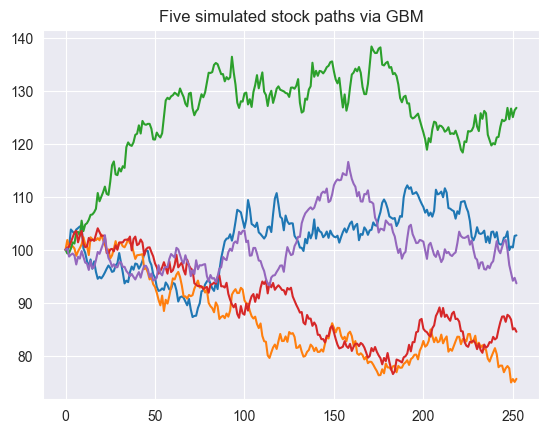

In [75]:
S0 = 100
t=1
mu=0
r = 0.0365
sigma = .2
nsteps = 252
nsims=5

stock_paths = GBM_model_stock(S0, t, r, mu, sigma, nsteps, nsims)

plt.figure()

plt.title("Five simulated stock paths via GBM")
for path in stock_paths:
    plt.plot(path)

plt.show()


## Geometric Asian options

The situation of geometric Asian options is easier to study primarily due to the fact that the product of log-normal distributions is also log-normal. This means that $A(T)$ is a log-normal distribution in the geometric case. We begin with the fixed strike case. For this, we will use the following notation:
* $\Phi$ is the cdf of the standard normal disctibution
* $b=\frac{1}{2}(r-\frac{1}{6}\sigma^2)$
* $$d_1 = \frac{\ln(S_0e^{bT}/K)+(T/2)(r+\sigma^2/6)}{\sigma\sqrt{T/3}}$$
* $$d_2=d_1-\sigma\sqrt{T/3}$$.

We then have that the fixed strike geometric Asian call option has fair market value $$C_0=S_0e^{-(r+\sigma^2/6)(T/2)}\Phi(d_1)-Ke^{-rT}\Phi(d_2).$$

In [76]:
def BS_estimated_value_geometric(S0, K, r, sigma, t):
    sixth_var = sigma**2/6
    sigma_G = sigma*np.sqrt(t/3)
    b = .5*(r-sixth_var)
    d1 = (np.log(S0*np.exp(b*t)/K)+t*(b+.5*sigma_G**2))/sigma_G
    d2 = d1-sigma_G

    return S0*np.exp((b-r)*t)*norm.cdf(d1)-K*np.exp(-r*t)*norm.cdf(d2)

We will now simulate several stock paths and check how good this model is in the ideal case.

In [77]:
def calculate_geometric_asian_option_value(stock_paths, K):
    log_of_returns = np.log(stock_paths)
    log_mean = np.mean(log_of_returns, axis=1)
    geometric_mean = np.exp(log_mean)
    C0=geometric_mean - K
    C0[C0<0]=0
    return C0

We will start by testing our models in the at-the-money case, risk-neutral, and with expiration time 1 year after the start of the contract.

In [78]:
S0 = 100
t=1
mu=0
r = 0.0365
sigma = .2
nsteps = 252
nsims=10000
K=100

stock_paths = GBM_model_stock(S0, t, r, mu, sigma, nsteps, nsims)

theoretical_value=BS_estimated_value_geometric(S0, K, r, sigma, t)

standard_error = np.std(calculate_geometric_asian_option_value(stock_paths, K))/np.sqrt(nsims)

print(f"The (discounted) average payout of {nsims} simulated ATM Asian geometric call options is {np.exp(-r*t)*np.mean(calculate_geometric_asian_option_value(stock_paths, K)):.2f}")
print("-"*100)
print(f"The theoretical value for such call options is {theoretical_value:.2f}")
print("-"*100)
print(f"The standard error for this calculation is {standard_error:.2f}")

The (discounted) average payout of 10000 simulated ATM Asian geometric call options is 5.24
----------------------------------------------------------------------------------------------------
The theoretical value for such call options is 5.20
----------------------------------------------------------------------------------------------------
The standard error for this calculation is 0.08


We will be interested later in what effect delta hedging has on the price distribution in the risk-free setting. To compare with later, we will graph the distribution.

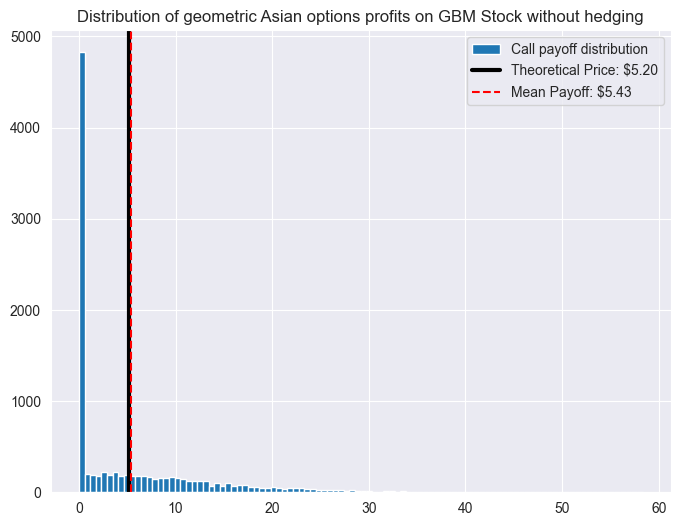

In [79]:
plt.figure(figsize = (8,6))

profits = calculate_geometric_asian_option_value(stock_paths, K)
    
plt.hist(profits, bins = 100, label= 'Call payoff distribution')
    
plt.axvline(BS_estimated_value_geometric(S0, K, r, sigma, t), color = 'black', lw = 3, label = f'Theoretical Price: ${BS_estimated_value_geometric(S0, K, r, sigma, t):.2f}')
    
plt.axvline(np.mean(profits), ls = '--', color = 'red', label = f'Mean Payoff: ${np.mean(profits):.2f}')
    
plt.title(f'Distribution of geometric Asian options profits on GBM Stock without hedging')
plt.legend()
plt.show()

We will now test our model against data from yfinance. We will again focus on ATM pricing, and will start without hedging.

In [80]:
tickers = ['AAPL', 'TSLA', 'F', 'HD', 'GM', 'SPY', '^GSPC', 'VTI', 'QQQ']


stock_data = yf.download(tickers, interval = '1d', start = '2015-01-01', end = '2015-12-31')

C:\Users\noahr\AppData\Local\Temp\ipykernel_17544\4080201909.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(tickers, interval = '1d', start = '2015-01-01', end = '2015-12-31')
[*********************100%***********************]  9 of 9 completed


In [81]:
for ticker in tickers:
    stock_data['time_to_expiration', ticker] = (stock_data.index[-1] - stock_data.index).total_seconds()/(60*60*24*365)
    mask = stock_data.index[21:]
    volitility_mask = stock_data.index[:21]
    estimated_std = np.log(stock_data.loc[volitility_mask, ('Close',ticker)]).std()*np.sqrt(252/20)
    K = stock_data['Close',ticker].iloc[21]
    call_payout = calculate_geometric_asian_option_value(stock_data.loc[mask, ('Close', ticker)].to_numpy()[np.newaxis,:], K)[0]
    estimated_value = BS_estimated_value_geometric(K,K,r,estimated_std,stock_data['time_to_expiration',ticker].iloc[21])
    print(f'The (geometric) average closing price for {ticker} over this period was {np.exp(np.mean(np.log(stock_data.loc[mask,('Close',ticker)].to_numpy()))):.2f}')
    print(f'For stock {ticker}, an ATM (strike ${K:.2f}) geometric Asian option starting on 21 January 2015 and expiring on 31 December 2015 would be have payout ${call_payout:.2f}')
    print(f'The estimated payout for {ticker} is ${estimated_value:.2f}')
    print("-"*100)
    
    

The (geometric) average closing price for AAPL over this period was 27.02
For stock AAPL, an ATM (strike $26.30) geometric Asian option starting on 21 January 2015 and expiring on 31 December 2015 would be have payout $0.71
The estimated payout for AAPL is $0.89
----------------------------------------------------------------------------------------------------
The (geometric) average closing price for TSLA over this period was 15.42
For stock TSLA, an ATM (strike $14.56) geometric Asian option starting on 21 January 2015 and expiring on 31 December 2015 would be have payout $0.86
The estimated payout for TSLA is $0.51
----------------------------------------------------------------------------------------------------
The (geometric) average closing price for F over this period was 8.52
For stock F, an ATM (strike $8.78) geometric Asian option starting on 21 January 2015 and expiring on 31 December 2015 would be have payout $0.00
The estimated payout for F is $0.18
--------------------

We will now analyze the situation with $\Delta$-hedging. While the formula is not as simple as the Black-Scholes $\Delta$, one pleasant feature about geometric Asain options is that there is a closed form solution for the $\Delta$. Working through the partial derivatives, we find that $$\Delta_{C_0} = e^{-(r+\sigma^2/6)(T/2)}\Phi(d_1) + \frac{e^{bT-(r+\sigma^2/6)(T/2)}}{S_0K\sigma\sqrt{T/3}}\phi(d_1)-\frac{e^{bT-rT}}{S_0\sigma\sqrt{T/3}}\phi(d_2)$$ using the chain rule.

In [82]:
def geometric_asian_delta(S0,K,r,sigma,t):
    sixth_var = sigma**2/6
    root_t_thirds = np.sqrt(t/3)
    sigma_G = sigma*root_t_thirds
    b = .5*(r-sixth_var)
    d1 = (np.log(S0*np.exp(b*t)/K)+t*(b+.5*sigma_G**2))/sigma_G
    d2 = d1-sigma_G
    discount = -.5*(r+sixth_var)*t
    delta = np.exp(discount)*norm.cdf(d1) + np.exp(b*t+discount)*norm.pdf(d1)/(S0*K*sigma_G) - np.exp(b*t-r*t)*norm.pdf(d2)/(S0*sigma_G)
    return delta
    

We are now ready to study the theoretical performance of geometric Asian options with hedging. We will assume that there are no transaction fees. We will analyse the situation of hedging at every avaliable opportunity.

In [83]:
def GBM_geometric_asian_with_hedging(S0,K,t,mu,r,sigma,nsteps,nsims):

    stock_paths = GBM_model_stock(S0,t, r, mu,sigma, nsteps,nsims)
    
    call_payout_discounted = calculate_geometric_asian_option_value(stock_paths, K)
    
    times = np.linspace(0, t, nsteps + 1)
    
    dt = t/nsteps
    
    
    deltas = geometric_asian_delta(stock_paths[:,0:nsteps], K, sigma, (t- times)[0:nsteps], r)
    
    stock_profits_discounted = (stock_paths[:,1:nsteps + 1] - stock_paths[:,0:nsteps]*np.exp(r*dt))*np.exp(-r*times[1:nsteps+1])*deltas
    
    
    total_stock_profits = np.sum(stock_profits_discounted, axis = 1)
    
    
    profit_of_call_with_hedging = call_payout_discounted - total_stock_profits

    return profit_of_call_with_hedging


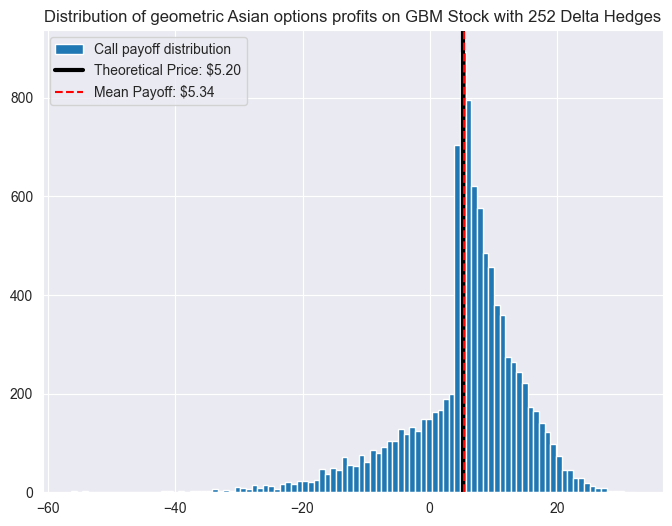

In [84]:
S0 = 100
t=1
mu=0
r = 0.0365
sigma = .2
nsteps = 252
nsims=10000
K=100

profits = GBM_geometric_asian_with_hedging(S0,K,t,mu,r,sigma,nsteps,nsims)

plt.figure(figsize = (8,6))
    
plt.hist(profits, bins = 100, label= 'Call payoff distribution')
    
plt.axvline(BS_estimated_value_geometric(S0, K, r, sigma, t), color = 'black', lw = 3, label = f'Theoretical Price: ${BS_estimated_value_geometric(S0, K, r, sigma, t):.2f}')
    
plt.axvline(np.mean(profits), ls = '--', color = 'red', label = f'Mean Payoff: ${np.mean(profits):.2f}')
    
plt.title(f'Distribution of geometric Asian options profits on GBM Stock with {nsteps} Delta Hedges')
plt.legend()
plt.show()


We will now repeate the test of real-world data with hedging included

In [85]:
for ticker in tickers:
    stock_data['time_to_expiration', ticker] = (stock_data.index[-1] - stock_data.index).total_seconds()/(60*60*24*365)
    stock_data['log_returns', ticker] = np.log(stock_data['Close', ticker].pct_change()+1)
    stock_data['volatility', ticker] = stock_data['log_returns', ticker].rolling(window = 21).std()*np.sqrt(252/20)
    mask = stock_data.index[21:]
    stock_data['delta',ticker] = np.nan
    volitility_mask = stock_data.index[:21]
    estimated_std = stock_data['volatility',ticker].iloc[21]
    K = stock_data['Close',ticker].iloc[21]
    call_payout = calculate_geometric_asian_option_value(stock_data.loc[mask, ('Close', ticker)].to_numpy()[np.newaxis,:], K)[0]
    estimated_value = BS_estimated_value_geometric(K,K,r,estimated_std,stock_data['time_to_expiration',ticker].iloc[21])
    stock_data.loc[mask, ('delta', ticker)]= geometric_asian_delta(
        stock_data.loc[mask, ('Close', ticker)],
        K,
        r,
        stock_data.loc[mask, ('volatility', ticker)],
        stock_data.loc[mask, ('time_to_expiration', ticker)])
    hedging = np.sum(stock_data['Close',ticker].diff()*\
                stock_data['delta',ticker].shift(1))
    call_payout = call_payout - hedging
    print(f'The (geometric) average closing price for {ticker} over this period was {np.exp(np.mean(np.log(stock_data.loc[mask,('Close',ticker)].to_numpy()))):.2f}')
    print(f'For stock {ticker}, an ATM (strike ${K:.2f}) geometric Asian option starting on 21 January 2015 and expiring on 31 December 2015 with daily hedging would be have payout ${call_payout:.2f}')
    print(f'The estimated payout for {ticker} is ${estimated_value:.2f}')
    print("-"*100)
    
    

The (geometric) average closing price for AAPL over this period was 27.02
For stock AAPL, an ATM (strike $26.30) geometric Asian option starting on 21 January 2015 and expiring on 31 December 2015 with daily hedging would be have payout $4.37
The estimated payout for AAPL is $0.67
----------------------------------------------------------------------------------------------------
The (geometric) average closing price for TSLA over this period was 15.42
For stock TSLA, an ATM (strike $14.56) geometric Asian option starting on 21 January 2015 and expiring on 31 December 2015 with daily hedging would be have payout $5.92
The estimated payout for TSLA is $0.39
----------------------------------------------------------------------------------------------------
The (geometric) average closing price for F over this period was 8.52
For stock F, an ATM (strike $8.78) geometric Asian option starting on 21 January 2015 and expiring on 31 December 2015 with daily hedging would be have payout $0.43